In [1]:
import cv2
import time
import datetime
import pyautogui
import tkinter as tk
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import os
import pyvirtualcam

In [2]:
mp_manos= mp.solutions.hands

manos=mp_manos.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
manos_videos=mp_manos.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

mp_dibujo= mp.solutions.drawing_utils

In [3]:
def detectarPuntosManos(imagen, mano, dibujo = True, display = True):
    
    if imagen is None:
        return
    imagen_salida=imagen.copy()

    imgRGB= cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)

    results=mano.process(imgRGB)

    if results.multi_hand_landmarks and dibujo:

        for hand_landmarks in results.multi_hand_landmarks:
            
            mp_dibujo.draw_landmarks(imagen_salida, landmark_list= hand_landmarks,
                                    connections= mp_manos.HAND_CONNECTIONS,
                                    landmark_drawing_spec=mp_dibujo.DrawingSpec(color=(255,255,255),
                                                                                thickness=2, circle_radius=2),
                                    connection_drawing_spec=mp_dibujo.DrawingSpec(color=(0,255,0),
                                                                                thickness=2, circle_radius=2))

    if display:

        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(imagen[:,:,::-1]);plt.title("Imagen Original");plt.axis('off');
        plt.subplot(122);plt.imshow(imagen_salida[:,:,::-1]);plt.title("Salida");plt.axis('off');
    else:
        return imagen_salida, results

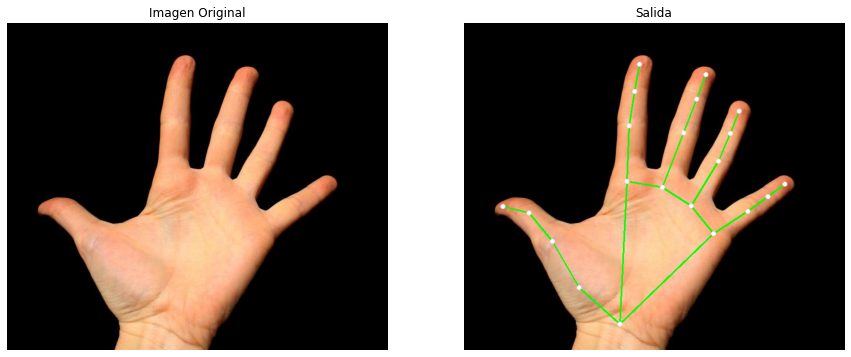

In [4]:
imagen =cv2.imread('media/prueba.jpg')
detectarPuntosManos(imagen, manos, display=True)


In [5]:
def contarDedos(imagen, results, dibujo=True, display=True):
    altura, ancho, _ =imagen.shape
    if imagen is None:
        return
    imagen_salida=imagen.copy()
    count={'RIGHT':0, 'LEFT':0}
    punta_dedos_ids=[mp_manos.HandLandmark.INDEX_FINGER_TIP, mp_manos.HandLandmark.MIDDLE_FINGER_TIP,
                    mp_manos.HandLandmark.RING_FINGER_TIP, mp_manos.HandLandmark.PINKY_TIP]
    
    estado_dedos={'RIGHT_THUMB': False, 'RIGHT_INDEX': False, 'RIGHT_MIDDLE': False, 'RIGHT_RING': False,
                        'RIGHT_PINKY': False, 'LEFT_THUMB': False, 'LEFT_INDEX': False, 'LEFT_MIDDLE': False,
                        'LEFT_RING': False, 'LEFT_PINKY': False}
                        
    for index_mano, mano_info in enumerate(results.multi_handedness):

        etiqueta_mano=mano_info.classification[0].label
        etiqueta_marcas=results.multi_hand_landmarks[index_mano]

        for punta_indice in punta_dedos_ids:
            nombre_dedo= punta_indice.name.split("_")[0]
            if(etiqueta_marcas.landmark[punta_indice].y < etiqueta_marcas.landmark[punta_indice -2].y):
                estado_dedos[etiqueta_mano.upper()+"_"+nombre_dedo]=True
                count[etiqueta_mano.upper()]+=1
                
        pulgar_punta_x=etiqueta_marcas.landmark[mp_manos.HandLandmark.THUMB_TIP].x
        pulgar_mcp_x=etiqueta_marcas.landmark[mp_manos.HandLandmark.THUMB_TIP -2].x

        if(etiqueta_mano=='Right' and (pulgar_punta_x < pulgar_mcp_x)) or (etiqueta_mano=='Left' and (pulgar_punta_x > pulgar_mcp_x)):
            estado_dedos[etiqueta_mano.upper()+"_THUMB"]=True
            count[etiqueta_mano.upper()]+= 1

    if dibujo:
        cv2.putText(imagen_salida, "Dedos totales: ", (10,25), cv2.FONT_HERSHEY_COMPLEX, 1,(20,255,255),2)
        cv2.putText(imagen_salida, str(sum(count.values())), (ancho//2-150,240), cv2.FONT_HERSHEY_SIMPLEX,8.9, (20,255,155),10,10)

    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(imagen_salida[:,:,::-1]);plt.title("Imagen  salida");plt.axis('off');
    else:
        return imagen_salida, estado_dedos,count

In [6]:
camera_video=cv2.VideoCapture(1)
camera_video.set(3,1280)
camera_video.set(4,960)


cv2.namedWindow('Fingers Counter', cv2.WINDOW_NORMAL)
while camera_video.isOpened():
    ok, frame=camera_video.read()
    if not ok:
        continue
    frame=cv2.flip(frame,1)
    frame, results= detectarPuntosManos(frame, manos_videos, display=False)
    if results.multi_hand_landmarks:
        frame, estado_dedos, count= contarDedos(frame, results, display=False)
    cv2.imshow('Fingers Counter', frame)
    k=cv2.waitKey(1) & 0xFF
    e=str(datetime.datetime.now())
    f=e.replace(":","")
    g=f.replace(".","")
    h=g.replace(" ","")
    if(k==27):
        break
    if(k==32):
        
        pyautogui.screenshot('./ss/'+h+'.png')
    
camera_video.release()
cv2.destroyAllWindows()



In [7]:
def reconocimientoGestos(image, estados_dedos,contador, dibujo=True, display=True):
    if image is None:
        return
    imagen_salida=image.copy()
    etiqueta_manos=['RIGHT', 'LEFT']
    gestos_manos={'RIGHT':"UNKNOWN", 'LEFT':"UNKOWN"}

    for hand_index, etiqueta_manos in enumerate(etiqueta_manos):
        color=(0,0,255)
        
        if contador[etiqueta_manos] == 2 and estados_dedos[etiqueta_manos + '_MIDDLE'] and estados_dedos[
            etiqueta_manos + '_INDEX']:
            # Update the gesture value of the hand that we are iterating upon to V SIGN.
            gestos_manos[etiqueta_manos] = "V SIGN"
            color = (0, 255, 0)
        elif contador[etiqueta_manos] == 3 and estados_dedos[etiqueta_manos+'_THUMB'] and estados_dedos[etiqueta_manos+'_INDEX'] and estados_dedos[etiqueta_manos+'_PINKY']:
            gestos_manos[etiqueta_manos]="SPIDERMAN SIGN"
            
        if contador[etiqueta_manos]==5:
            gestos_manos[etiqueta_manos]="HIGH-FIVE SIGN"
            color=(0,255,0)
        if dibujo:
            cv2.putText(imagen_salida, etiqueta_manos +': '+gestos_manos[etiqueta_manos] , (10,(hand_index+1)* 60),
                        cv2.FONT_HERSHEY_PLAIN, 4, color, 5)
    if display:
        plt.figure(figsize=[15,15])
        plt.imshow(imagen_salida[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    else:
        return imagen_salida, gestos_manos


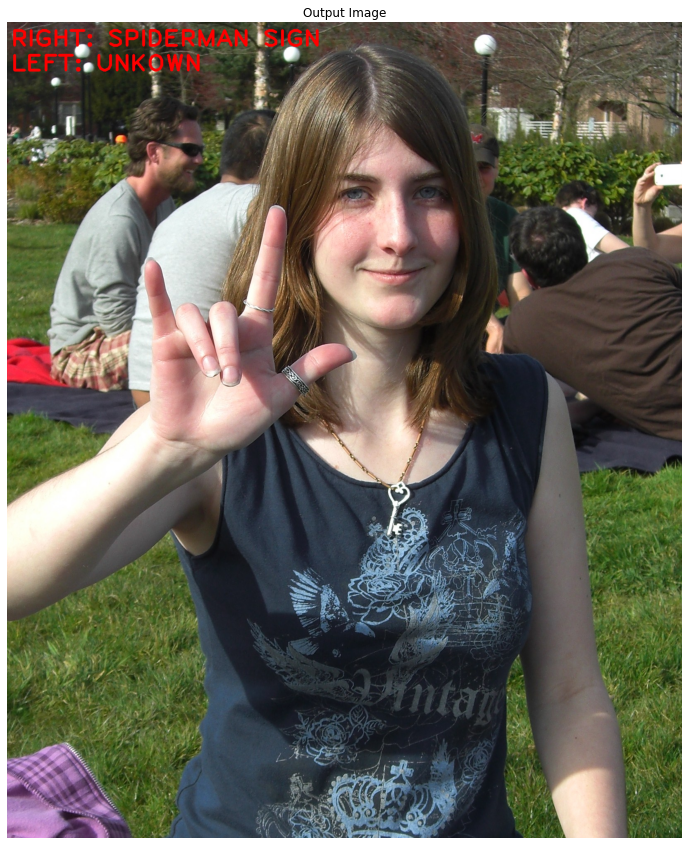

In [8]:
image = cv2.imread('media/sample1.jpg')
flipped_image = cv2.flip(image, 1)
_, results = detectarPuntosManos(flipped_image, manos, display=False)
if results.multi_hand_landmarks:
    output_image, fingers_statuses, contador =contarDedos(image, results, dibujo=False, display = False)
    reconocimientoGestos(image, fingers_statuses, contador)

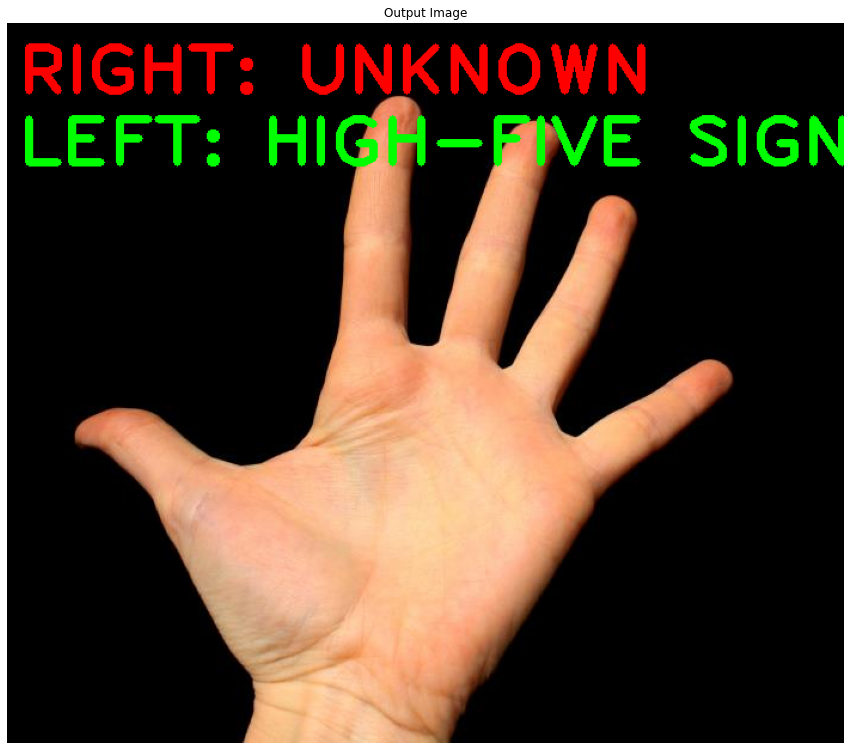

In [9]:
image = cv2.imread('media/prueba.jpg')
flipped_image = cv2.flip(image, 1)
_, results = detectarPuntosManos(flipped_image, manos, display=False)
if results.multi_hand_landmarks:
    output_image, fingers_statuses, contador =contarDedos(image, results, dibujo=False, display = False)
    reconocimientoGestos(image, fingers_statuses, contador)

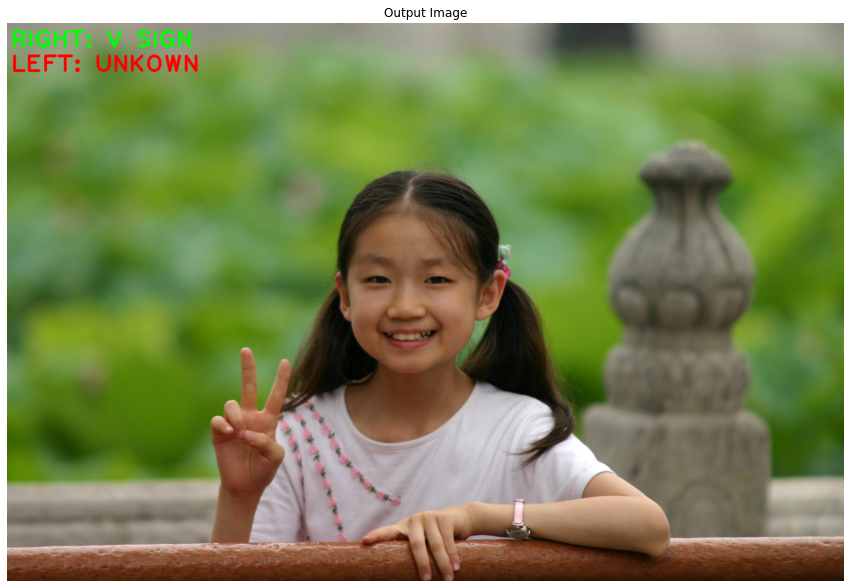

In [10]:
image = cv2.imread('media/sample2.jpg')
flipped_image = cv2.flip(image, 1)
_, results = detectarPuntosManos(flipped_image, manos, display=False)
if results.multi_hand_landmarks:
    output_image, fingers_statuses, contador =contarDedos(image, results, dibujo=False, display = False)
    reconocimientoGestos(image, fingers_statuses, contador)

In [12]:
camera_video=cv2.VideoCapture(1)
camera_video.set(3,1280)
camera_video.set(4,960)
contador=0

usuarioWindows=os.getenv('username')

direccion= 'c:/Users/'+usuarioWindows+'/desktop/Capturas/'
existe=os.path.exists(direccion)
if not existe:
    os.makedirs(direccion)

cv2.namedWindow('ScreenShot', cv2.WINDOW_NORMAL)
num_of_frames= 5
counter={'V SIGN':0}
captured_image= None
while camera_video.isOpened():
    contador=contador+1
    
    ok, frame=camera_video.read()
    filter_on = False
    if not ok:
        continue
    frame=cv2.flip(frame,1)
    frame, results= detectarPuntosManos(frame, manos_videos, display=False)
    if results.multi_hand_landmarks:
        frame, estado_dedos, count= contarDedos(frame, results, display=False)

        _,hand_gestures=reconocimientoGestos(frame, estado_dedos, count, dibujo=False, display=False)
    
        if results.multi_hand_landmarks and any(hand_gestures=="V SIGN" for hand_gestures in hand_gestures.values()):
            counter['V SIGN']+=1
            if counter['V SIGN']==num_of_frames:
                filter_on=True
                counter['V SIGN']=0
    cv2.imshow('ScreenShot',frame)
    if filter_on:
        
        e=str(datetime.datetime.now())
        f=e.replace(":","")
        g=f.replace(".","")
        h=g.replace(" ","")
        pyautogui.screenshot(direccion+h+'.png')
    
    k = cv2.waitKey(1) & 0xFF
    #LENTO AL ESPERAR 300MILISEGUNDOS
    # cv2.waitKey(300)
    
    if(k == 27):
        break

camera_video.release()
cv2.destroyAllWindows()



KeyError: 'LEFT_PINKY'

: 